Linear Regression Reguralized

Se han recopilado datos socio demográficos y de recursos de salud por condado en los Estados Unidos y queremos descubrir si existe alguna relación entre los recursos sanitarios y los datos socio demográficos.

Para ello, es necesario que establezcas una variable objetivo (relacionada con la salud) para llevar a cabo el análisis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv")


In [2]:
data.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


In [3]:
data.shape

(3140, 108)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


In [5]:
print(data.dtypes.value_counts())

float64    61
int64      45
object      2
Name: count, dtype: int64


Revisión de nulos y duplicados

In [4]:
data.duplicated().sum()

np.int64(0)

In [5]:
# Eliminar duplicados / segunda forma
df_cleaned = data.drop_duplicates()

# Confirmar que ya no hay duplicados
print(f'Shape data set : {data.shape}')
print(f'Shape data set sin duplicados: {df_cleaned.shape}')

Shape data set : (3140, 108)
Shape data set sin duplicados: (3140, 108)


In [6]:
data.isnull().sum().sort_values(ascending=False)

fips                      0
TOT_POP                   0
0-9                       0
0-9 y/o % of total pop    0
19-Oct                    0
                         ..
CKD_prevalence            0
CKD_Lower 95% CI          0
CKD_Upper 95% CI          0
CKD_number                0
Urban_rural_code          0
Length: 108, dtype: int64

In [7]:
# Ver cuántos valores nulos hay por columna
missing = data.isnull().sum()
missing = missing[missing > 0]
print(missing.sort_values(ascending=False))


Series([], dtype: int64)


In [8]:
# Porcentaje de nulos por columna
null_percent = data.isnull().mean() * 100
null_percent = null_percent[null_percent > 0].sort_values(ascending=False)

El dataset no tiene valores nulos ni duplicados...

Eliminar columnas que no son importantes

In [9]:
var_categoricas = []
var_numericas= []

for col in data.columns:
    if data[col].dtype == 'object':
        var_categoricas.append(col)
    elif pd.api.types.is_numeric_dtype(data[col]):
        var_numericas.append(col)

print("Variables categóricas:")
print(var_categoricas)

print("\n")
print("Variables numéricas:")
print(var_numericas)

Variables categóricas:
['COUNTY_NAME', 'STATE_NAME']


Variables numéricas:
['fips', 'TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct', '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop', '30-39', '30-39 y/o % of total pop', '40-49', '40-49 y/o % of total pop', '50-59', '50-59 y/o % of total pop', '60-69', '60-69 y/o % of total pop', '70-79', '70-79 y/o % of total pop', '80+', '80+ y/o % of total pop', 'White-alone pop', '% White-alone', 'Black-alone pop', '% Black-alone', 'Native American/American Indian-alone pop', '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone', 'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone', 'Two or more races pop', '% Two or more races', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018', 'GQ_ESTIMATES_2018', 'R_birth_2018', 'R_death_2018', 'R_NATURAL_INC_2018', 'R_INTERNATIONAL_MIG_2018', 'R_DOMESTIC_MIG_2018', 'R_NET_MIG_2018', 'Less than a high school diploma 2014-18', 'High school diploma only 2014-18', "Some college or associate's degree 

Seleccionar variable objetivo

Posibles variables objetivo:

Anycondition_prevalence (prevalencia de cualquier condición médica)

Obesity_prevalence (prevalencia de obesidad)

Heart disease_prevalence (prevalencia de enfermedades cardíacas)

Median_Household_Income_2018 (variables socioeconómicas)

Unemployment_rate_2018 (variables socioeconómicas)

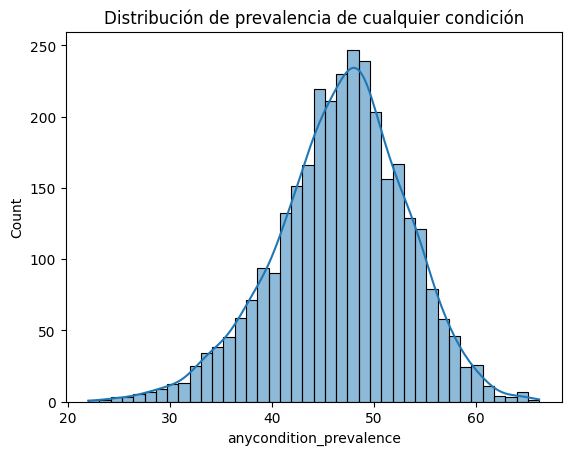

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data['anycondition_prevalence'], kde=True)
plt.title('Distribución de prevalencia de cualquier condición')
plt.show()

In [11]:
# valores unicos para la posible variable objetivo #1: Anycondition_prevalence
data['anycondition_prevalence'].unique()
#conteo
conteo_first=data['anycondition_prevalence'].value_counts()
print(len(conteo_first))

351


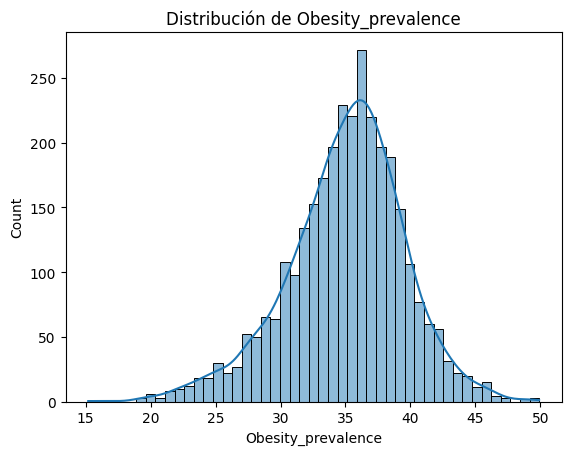

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data['Obesity_prevalence'], kde=True)
plt.title('Distribución de Obesity_prevalence')
plt.show()

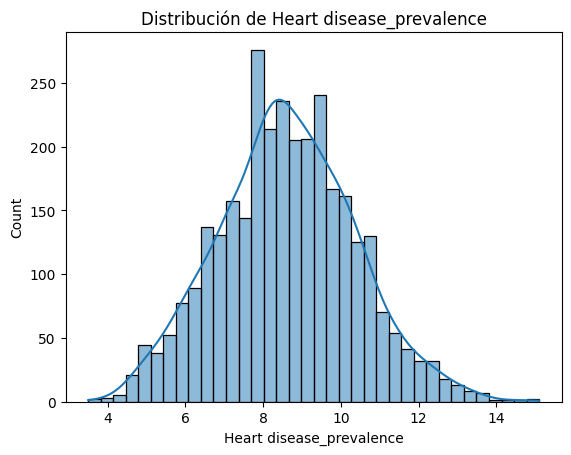

In [13]:
sns.histplot(data['Heart disease_prevalence'], kde=True)
plt.title('Distribución de Heart disease_prevalence')
plt.show()

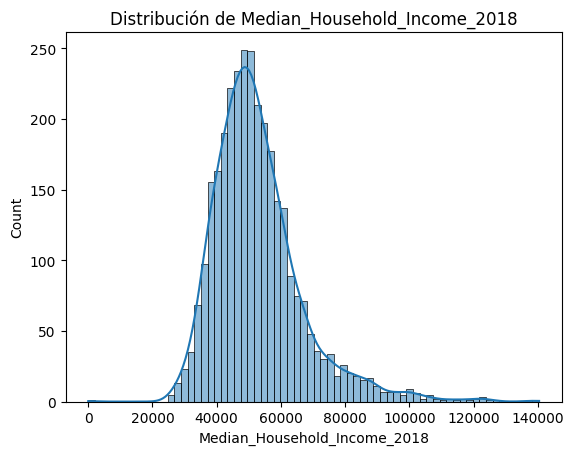

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data['Median_Household_Income_2018'], kde=True)
plt.title('Distribución de Median_Household_Income_2018')
plt.show()

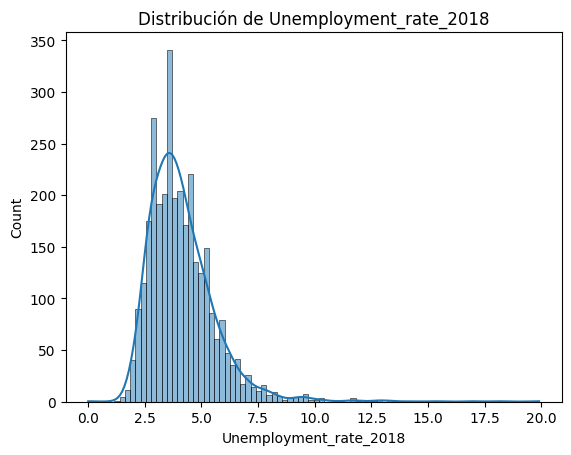

In [15]:
sns.histplot(data['Unemployment_rate_2018'], kde=True)
plt.title('Distribución de Unemployment_rate_2018')
plt.show()

## Correlación y heatmap

Seleccionamos algunas variables para hace el análisis de correlación

anycondition_prevalence Prevalencia (%) de cualquier condición médica o crónica en la población del área analizada.

Obesity_prevalence Prevalencia (%) de obesidad en la población.

Heart disease_prevalence Prevalencia (%) de enfermedades cardíacas en la población.

Median_Household_Income_2018 Ingreso mediano anual por hogar en dólares para el año 2018.

Unemployment_rate_2018 Tasa de desempleo (%) en la población activa durante el año 2018.

Population Aged 60+ Número total de personas con 60 años o más en esa área.

Percent of Population Aged 60+ Porcentaje (%) de la población total que tiene 60 años o más.

White-alone pop Número total de personas que se identifican únicamente como raza blanca.

Black-alone pop Número total de personas que se identifican únicamente como raza negra o afroamericana.

Asian-alone pop Número total de personas que se identifican únicamente como raza asiática.

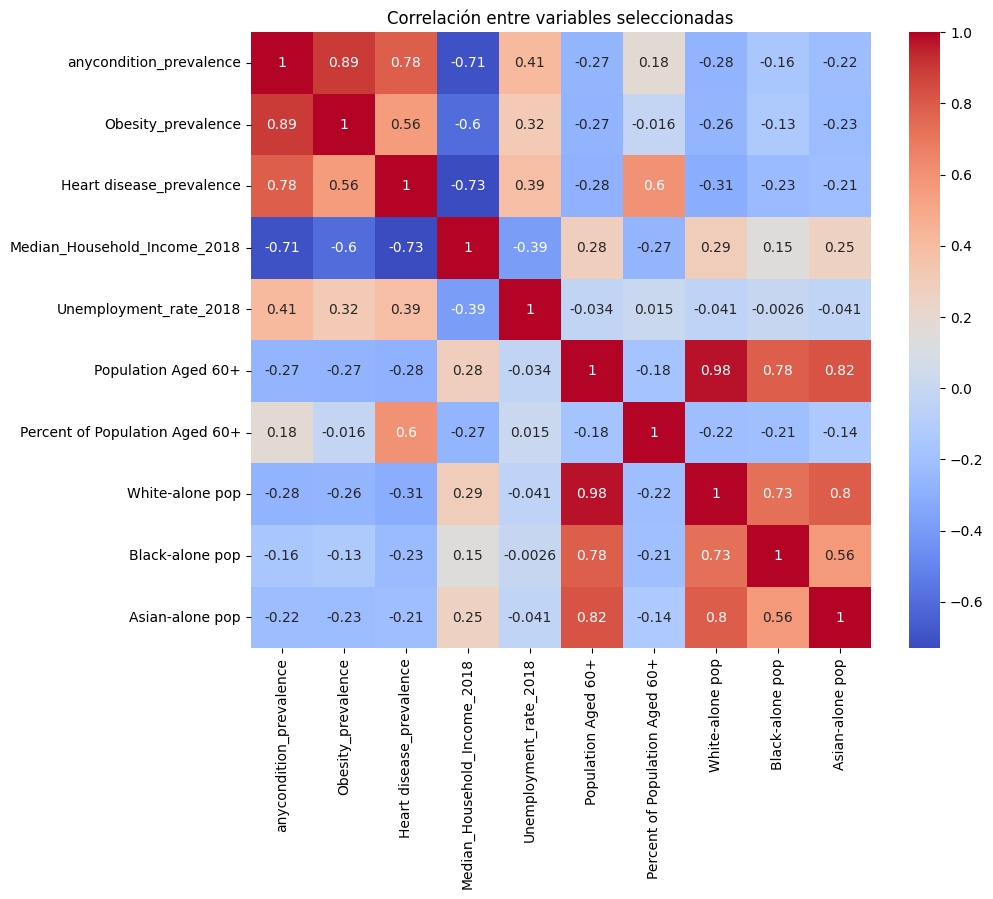

In [16]:
import numpy as np

cols_to_check = ['anycondition_prevalence', 'Obesity_prevalence', 'Heart disease_prevalence',
                 'Median_Household_Income_2018', 'Unemployment_rate_2018',
                 'Population Aged 60+', 'Percent of Population Aged 60+',
                 'White-alone pop', 'Black-alone pop', 'Asian-alone pop']

corr_matrix = data[cols_to_check].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlación entre variables seleccionadas')
plt.show()

ingreso y prevalencia de obesidad:

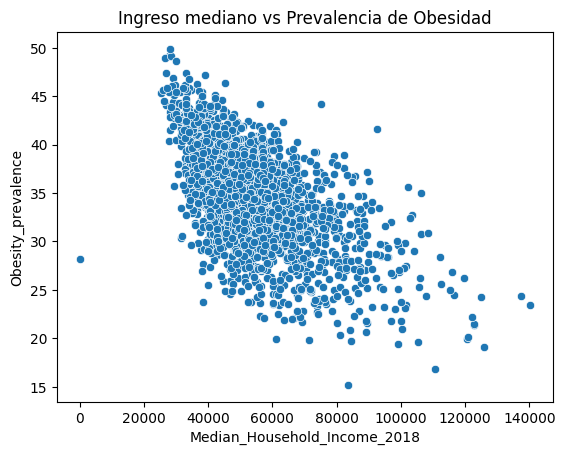

In [17]:
sns.scatterplot(data=data, x='Median_Household_Income_2018', y='Obesity_prevalence')
plt.title('Ingreso mediano vs Prevalencia de Obesidad')
plt.show()

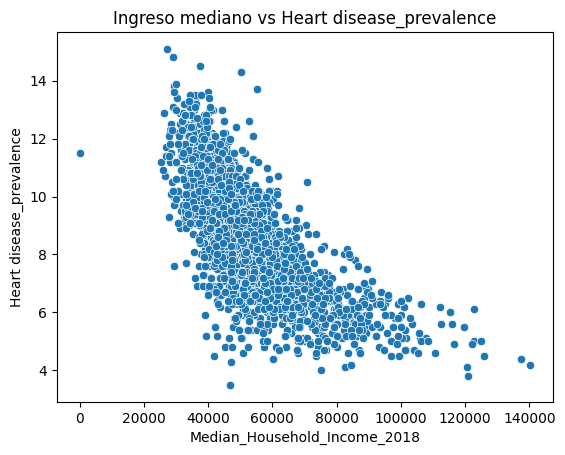

In [18]:
sns.scatterplot(data=data, x='Median_Household_Income_2018', y='Heart disease_prevalence')
plt.title('Ingreso mediano vs Heart disease_prevalence')
plt.show()

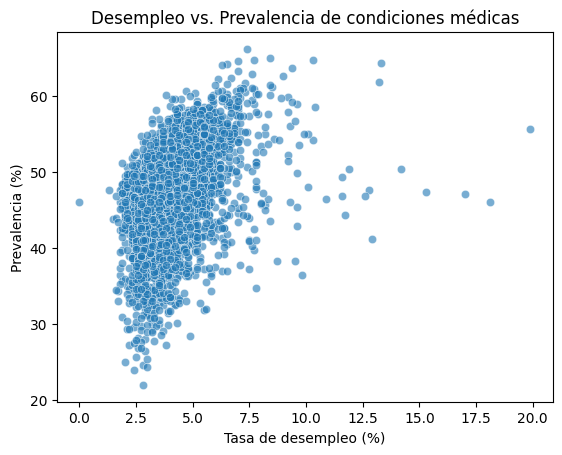

In [19]:
sns.scatterplot(
    data=data,
    x='Unemployment_rate_2018',
    y='anycondition_prevalence',
    alpha=0.6
)
plt.title('Desempleo vs. Prevalencia de condiciones médicas')
plt.xlabel('Tasa de desempleo (%)')
plt.ylabel('Prevalencia (%)')
plt.show()


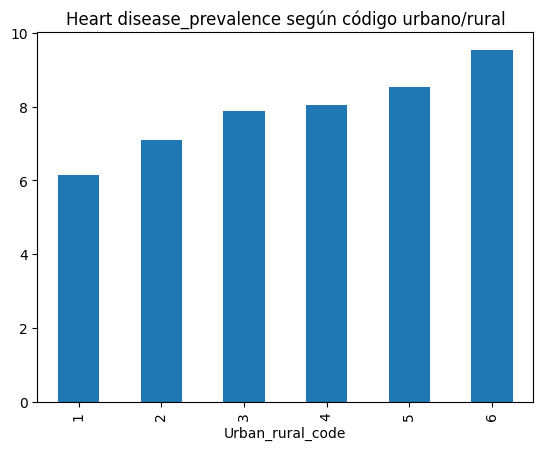

In [20]:
data.groupby('Urban_rural_code')['Heart disease_prevalence'].mean().plot(kind='bar')
plt.title('Heart disease_prevalence según código urbano/rural')
plt.show()

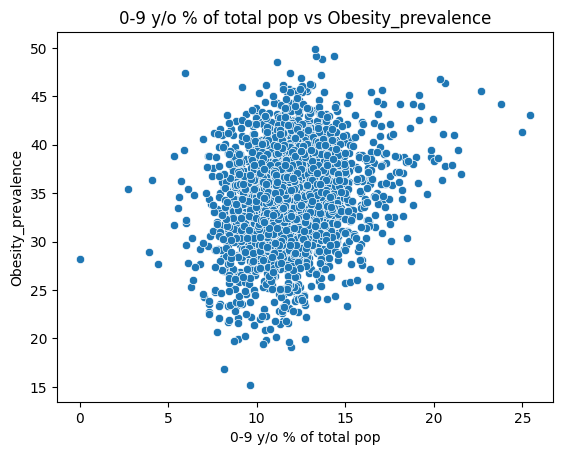

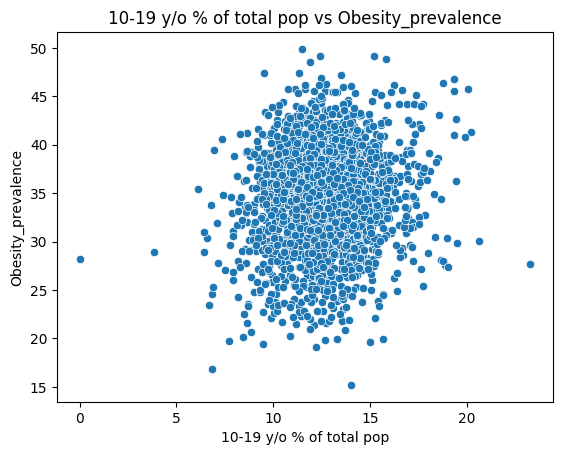

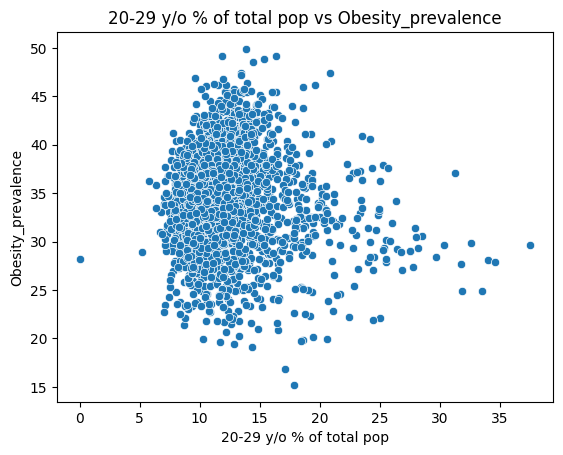

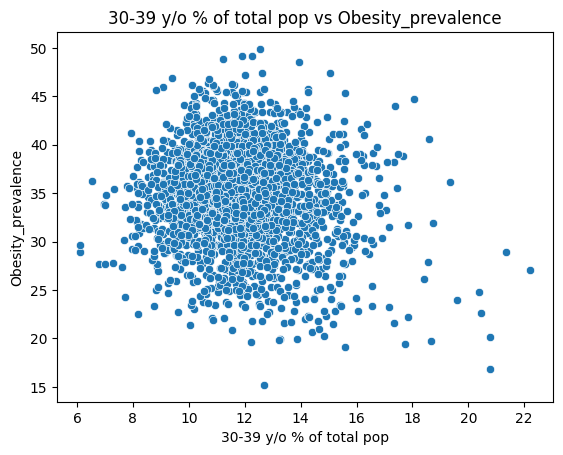

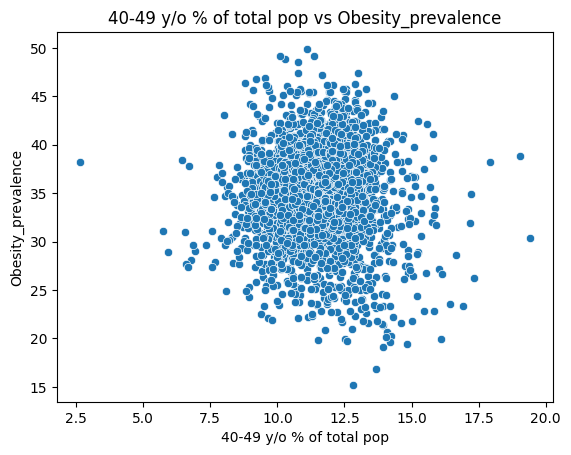

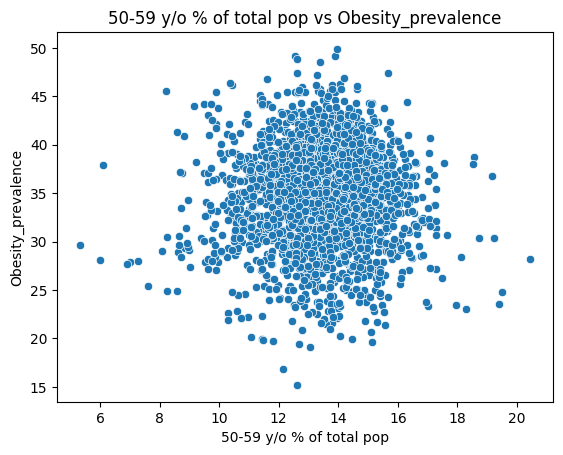

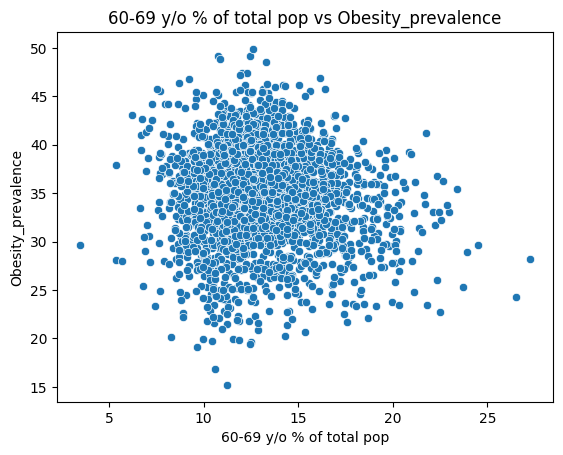

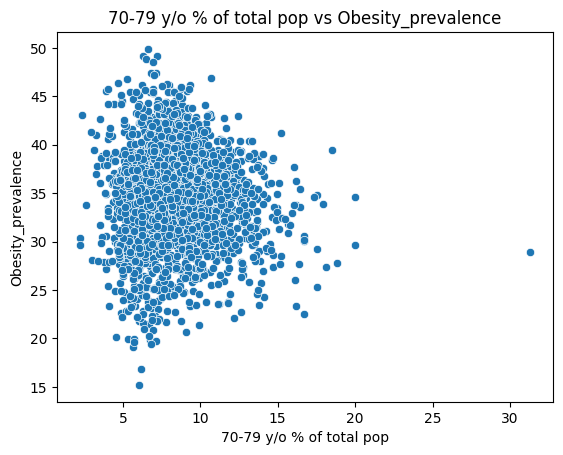

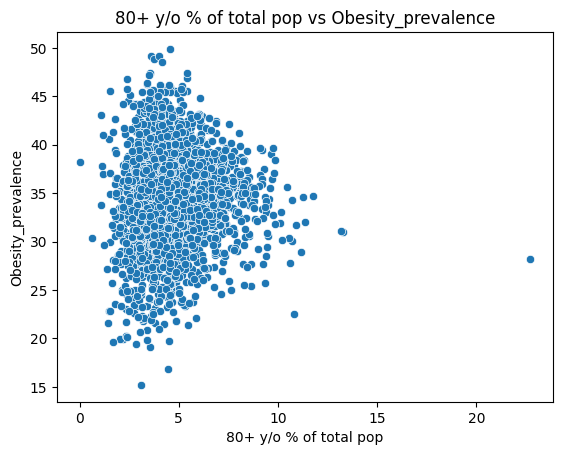

In [21]:
age_cols = ['0-9 y/o % of total pop', '10-19 y/o % of total pop', '20-29 y/o % of total pop',
            '30-39 y/o % of total pop', '40-49 y/o % of total pop', '50-59 y/o % of total pop',
            '60-69 y/o % of total pop', '70-79 y/o % of total pop', '80+ y/o % of total pop']

for col in age_cols:
    sns.scatterplot(data=data, x=col, y='Obesity_prevalence')
    plt.title(f'{col} vs Obesity_prevalence')
    plt.show()

Posibles variables target de acuerdo a indicadores de salud:

anycondition_prevalence (prevalencia de cualquier condición médica)

Obesity_prevalence (prevalencia de obesidad)

Heart disease_prevalence (prevalencia de enfermedades cardíacas)

O también variables socioeconómicas como Median_Household_Income_2018 o Unemployment_rate_2018

In [22]:
print("Variables categóricas:")
print(var_categoricas)

print("Variables numericas:")
print(var_numericas)

Variables categóricas:
['COUNTY_NAME', 'STATE_NAME']
Variables numericas:
['fips', 'TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct', '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop', '30-39', '30-39 y/o % of total pop', '40-49', '40-49 y/o % of total pop', '50-59', '50-59 y/o % of total pop', '60-69', '60-69 y/o % of total pop', '70-79', '70-79 y/o % of total pop', '80+', '80+ y/o % of total pop', 'White-alone pop', '% White-alone', 'Black-alone pop', '% Black-alone', 'Native American/American Indian-alone pop', '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone', 'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone', 'Two or more races pop', '% Two or more races', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018', 'GQ_ESTIMATES_2018', 'R_birth_2018', 'R_death_2018', 'R_NATURAL_INC_2018', 'R_INTERNATIONAL_MIG_2018', 'R_DOMESTIC_MIG_2018', 'R_NET_MIG_2018', 'Less than a high school diploma 2014-18', 'High school diploma only 2014-18', "Some college or associate's degree 20

In [ ]:
data.drop(['STATE_NAME'], axis=1, inplace=True)
data.drop(['COUNTY_NAME'], axis=1, inplace=True)

In [27]:
variable_objetivo=data['Obesity_prevalence']

In [25]:
# Eliminar columnas correlacionadas con la variable objetivo
X = data.drop(columns=['Obesity_prevalence', 'anycondition_prevalence', 'Heart disease_prevalence'])
y = data['Obesity_prevalence']

In [26]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Mostrar tamaños de los subconjuntos
print(f"Tamaño de X_train: {X_train_raw.shape}")
print(f"Tamaño de X_test: {X_test_raw.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de y_test: {y_test.shape}")

Tamaño de X_train: (2512, 103)
Tamaño de X_test: (628, 103)
Tamaño de y_train: (2512,)
Tamaño de y_test: (628,)


In [27]:
# Escalar con StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)


In [28]:
#Entrenar el modelo
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train) # usar datos escalados

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
# 3. Predicción
y_pred_first = model.predict(X_test)
y_pred_first

In [44]:
mse = mean_squared_error(y_test, y_pred_first)
r2 = r2_score(y_test, y_pred_first)
print(f"\nMean Squared Error (MSE): {mse}")
print(f"R2 Score: {r2}")



Mean Squared Error (MSE): 0.0034867207835304038
R2 Score: 0.9998311489556713


## Modelo ridge

In [31]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [32]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [33]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Predicción
y_pred_two = ridge.predict(X_test)

# Métricas
print("Error cuadratico medio:", mean_squared_error(y_test, y_pred_two))
print("Raiz cuadrada del error cuadratico medio RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_two)))
print("Coeficiente de determinación :", r2_score(y_test, y_pred_two))

Error cuadratico medio: 0.003484041943828553
Raiz cuadrada del error cuadratico medio RMSE: 0.05902577355552872
Coeficiente de determinación : 0.9998312786835472


In [34]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Definición del espacio de búsqueda para alpha
ridge_m = {'alpha': np.logspace(-5, 5, 200)}

# GridSearchCV con validación cruzada
ridge_grid = GridSearchCV(
    Ridge(),
    ridge_m,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
    cv=5
)

# Entrenamiento con los datos de entrenamiento
ridge_grid.fit(X_train, y_train)

# Mejor alpha encontrado
print("Mejor alpha (Ridge):", ridge_grid.best_params_)

# Crear y entrenar el mejor modelo
best_ridge = Ridge(alpha=ridge_grid.best_params_['alpha'])
best_ridge.fit(X_train, y_train)


Mejor alpha (Ridge): {'alpha': np.float64(0.8406652885618334)}


,alpha,np.float64(0.8406652885618334)
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [43]:
# Predicción en conjunto de prueba
y_pred_ridge = best_ridge.predict(X_test)

# Evaluación del modelo
print(f"MSE: {mean_squared_error(y_test, y_pred_ridge)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge))}")
print(f"R^2 Score: {r2_score(y_test, y_pred_ridge)}")

MSE: 0.0034811494474282023
RMSE: 0.05900126649003564
R^2 Score: 0.9998314187581526


## Modelo Lasso

In [42]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Entrenar modelo Lasso con alpha=1.0
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)

# Predicción
y_pred_lasso = lasso.predict(X_test)

# Evaluación
print("Lasso - Resultados:")
print(f"MSE: {mean_squared_error(y_test, y_pred_lasso)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso))}")
print(f"R2 Score: {r2_score(y_test, y_pred_lasso)}")


Lasso - Resultados:
MSE: 1.026263268290499
RMSE: 1.0130465281962615
R2 Score: 0.9503012614529922


Lasso con búsqueda de hiperparámetros 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from scipy.stats import loguniform

# Distribución de búsqueda para alpha (valores entre 1e-4 y 10)
param_distributions = {
    'alpha': loguniform(1e-4, 10)
}

# Configurar RandomizedSearchCV
random_search_lasso = RandomizedSearchCV(
    estimator=Lasso(max_iter=10000),
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Ajustar al conjunto de entrenamiento
random_search_lasso.fit(X_train, y_train)

# Mejor modelo
best_lasso = random_search_lasso.best_estimator_
best_alpha = random_search_lasso.best_params_['alpha']
print(f"\nMejor alpha encontrado: {best_alpha}")

# Evaluar en el conjunto de prueba
y_pred_best_lasso = best_lasso.predict(X_test)

print("\nLasso con RandomizedSearchCV - Resultados:")
print(f"MSE: {mean_squared_error(y_test, y_pred_best_lasso)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best_lasso))}")
print(f"R2 Score: {r2_score(y_test, y_pred_best_lasso)}")



Mejor alpha encontrado: 0.000840

Lasso con RandomizedSearchCV - Resultados:
MSE: 0.003455
RMSE: 0.058780
R² Score: 0.999833


In [40]:
# Obtener los coeficientes
import pandas as pd
import numpy as np

coeficientes = best_lasso.coef_

# Asociarlos con los nombres de las columnas
importancia = pd.Series(coeficientes, index=X.columns)

# Ver todas las variables eliminadas (coeficiente = 0)
variables_eliminadas = importancia[importancia == 0].index.tolist()

# Ver todas las variables seleccionadas (coeficiente ≠ 0)
variables_seleccionadas = importancia[importancia != 0].index.tolist()

print(f"Número de variables eliminadas: {len(variables_eliminadas)}")
print(f"Número de variables seleccionadas: {len(variables_seleccionadas)}")

# Mostrar top 10 variables más importantes (por valor absoluto del coef)
importancia.abs().sort_values(ascending=False).head(17)


Número de variables eliminadas: 86
Número de variables seleccionadas: 17


Obesity_Upper 95% CI                                                       2.260136
Obesity_Lower 95% CI                                                       2.255463
30-39 y/o % of total pop                                                   0.002701
Percent of adults completing some college or associate's degree 2014-18    0.002014
COPD_Upper 95% CI                                                          0.001906
% Two or more races                                                        0.001574
% White-alone                                                              0.001574
PCTPOV017_2018                                                             0.001234
Urban_rural_code                                                           0.001000
R_INTERNATIONAL_MIG_2018                                                   0.000722
Percent of adults with a high school diploma only 2014-18                  0.000714
Unemployment_rate_2018                                                     0

## Conclusiones:

El modelo lasso puso en  cero todos los coeficientes de las otras 86 variables porque no aportaban información adicional para predecir la variable objetivo seleccionada Obesity_prevalence o porque pueden estar correlacionadas con otras variables.

Se decide que por la gran cantida de columnas del modelo lasso con búsqueda de hiperparametro RandomSearch como el modelo final ya que nos da una forma más práctica de identificar las columnas realmente relevantes y los resultados del r2 y rsme son óptimos.

